<a href="https://colab.research.google.com/github/Mahantesh-Pattadkal-1993/CounterFactuals_GANs/blob/main/MNIST_CF_and_semi_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Setting up the path for GAN Training
import os
os.chdir('/content/gdrive/MyDrive/Github/CounterFactuals_GANs/MNIST')

In [3]:
#Import the libraries 
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from GAN_Models import DC_Generator, DC_Discriminator, Net, CNN, Net_logits
from utils import imshow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0




# Set random seed for reproducibility
manualSeed = 2021
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  2021


## Loading the Models


In [4]:
#Load the Generator  
# using the 150 epochs dataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

G = DC_Generator().to(device)
D = DC_Discriminator().to(device)


checkpoint = torch.load("Weights/G_checkpoint_latest_149.pth", map_location=torch.device('cuda'))
G.load_state_dict(checkpoint['state_dict'])
G.eval()

checkpoint = torch.load("Weights/D_checkpoint_latest_149.pth", map_location=torch.device('cuda'))
D.load_state_dict(checkpoint['state_dict'])
D.eval()

DC_Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(56, 112, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(112, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [5]:
#Load the Classifier Net_logits() and outputs :- softmax, logits
Classifier_model_logits = Net_logits().to(device)
Classifier_checkpoint = torch.load("Weights/Classifier_CNN_logits.pth", map_location=torch.device('cuda'))
Classifier_model_logits.load_state_dict(Classifier_checkpoint['state_dict'])
Classifier_model_logits.eval()

Net_logits(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Data Loaders

In [6]:
#Loading the data

mb_size = 10

transform = transforms.Compose(
		[transforms.ToTensor(),
		 transforms.Normalize((0.5,), (0.5,))])

trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=False, batch_size=mb_size)

dataIter = iter(trainLoader)

imgs, labels = dataIter.next()
imgs = imgs.to(device)

print(imgs.shape)
print(labels)
imgs.is_cuda

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([10, 1, 28, 28])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


True

tensor([[1.0000e+00, 8.4316e-11, 1.7799e-08, 5.8022e-12, 1.0352e-11, 1.9533e-13,
         2.2826e-09, 1.6658e-10, 1.5405e-11, 1.8834e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


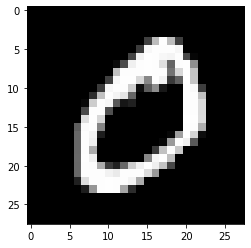

In [61]:
sample_image = imgs[1,:,:,:] #first image in this batch 
sample_image= sample_image.reshape([1,1,28,28]) #adding the dimension for batch size
sample_image = sample_image.to('cpu') #pushing it to cpu as that numpy conversion can be done


npimgs = sample_image[0].detach().numpy()
plt.imshow(npimgs[0],cmap='Greys_r')

sample_image = sample_image.to('cuda')
output, logits = Classifier_model_logits(sample_image)
print(output)

In [8]:
import torch
torch.manual_seed(100)
z = torch.randn(1, 100,1,1).to(device)
step_size = 0.001

## Latent Representation of the instance

avg_loss step  500tensor(0.5141, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1000tensor(0.3064, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1500tensor(0.2347, device='cuda:0', grad_fn=<DivBackward0>)
(1, 28, 28)


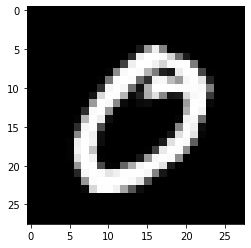

In [65]:
# Using the standard loss functions
#find the z_org that respresents the latent representation of given image


torch.cuda.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
z= torch.randn(1, 100,1,1).to(device)
step_size = 0.1

#Find the image closer to the original one but target prediction
MSE = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
#optimizer = optim.SGD([z_semi], lr=0.01) #not using optimiser here


def latent_representation(z,sample_image):
  overall_loss, loss , avg_loss = 0,10,0
  i=1

  while (loss>=0.09):
    z.requires_grad = True
    loss1 = MSE(sample_image,G(z)) #pixel loss
    loss2 = MSE(Classifier_model_logits(G(z))[0] , Classifier_model_logits(sample_image)[0]) #diference in pred of both images
    
    loss = loss1 + loss2
    #print(loss)

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size

 


    i = i+1


    overall_loss= overall_loss + loss
    if (i%500==0):
            
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      overall_loss = 0 
    

  return z

z_org = latent_representation(z,sample_image)

G_img= G(z_org) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')




In [64]:
Classifier_model_logits(G(z_org))[0]

tensor([[9.1966e-01, 2.8156e-08, 4.0090e-06, 1.0952e-04, 1.2491e-08, 1.4880e-04,
         7.8376e-02, 5.2421e-09, 1.6444e-03, 5.6645e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
MSE(sample_image,G(z_org))

tensor(0.2471, device='cuda:0', grad_fn=<MseLossBackward>)

## Counterfactual Calculations : Using latent dimension

In [24]:
#Using nn.losses
#find Cfs based on given set of targets

torch.cuda.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.01

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.SGD([z_semi], lr=0.01)


#using latent dimension distance
latent_z = []
for cnt in range(1,2,1):
  z_semi = z_org.clone().detach().to(device)

  overall_loss = 0
  i=1
  while (i<=10000):
    z_semi.requires_grad = True
        
    loss1 = criterion1(z_org,z_semi) # distance using MSE
    loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))

       
    #loss =  loss1 + loss2  # without PR
    loss = loss1 + loss2 + 0.1*loss3 #with PR
    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1
    overall_loss= overall_loss + loss 

    if (i%1000==0):
           
      avg_loss = overall_loss/1000.0
      print(" avg_loss " + " digit "+ str(cnt) +" step " + " " +str(i) + str (avg_loss))
     
      overall_loss = 0 
  latent_z.append(z_semi)
  
  

 avg_loss  digit 1 step  1000tensor(0.3414, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  2000tensor(0.1017, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  3000tensor(0.0930, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  4000tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  5000tensor(0.0806, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  6000tensor(0.0763, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  7000tensor(0.0721, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  8000tensor(0.0671, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  9000tensor(0.0655, device='cuda:0', grad_fn=<DivBackward0>)
 avg_loss  digit 1 step  10000tensor(0.0649, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
#Find the Cfs using loss function which also takes into consideration the pixel loss

"""
Loss1 - L1 dist between z and z org
Loss4 - L1 dist between sample img and G(z)
Loss2 - CE loss for intended class
Loss3 - Plausibility loss
"""

torch.cuda.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.optim as optim
import torch

torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.01

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.Adam([z_semi], lr=0.01)


#using latent dimension distance
latent_z_journey = [z_org]
for cnt in range(9,10,1):
  z_semi = z_org.clone().detach().to(device)

  overall_loss = 0
  i=1
  while (i<=10000):
    z_semi.requires_grad = True
        
    loss1 = l1_loss(z_org,z_semi) # distance using L1
    loss4 = l1_loss(sample_image,G(z_semi))
    loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))

       
    #loss =  loss1 + loss2 + loss4 # without PR
    loss = loss1 + loss2 + loss4 + 0.1*loss3 #with PR
    #print(loss)
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()

    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - (z_semi.grad * step_size)
    i = i+1
    overall_loss= overall_loss + loss 
    
    if (i%100==0):
           
      avg_loss = overall_loss/100.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      overall_loss = 0 
      latent_z_journey.append(z_semi)
  

  
  

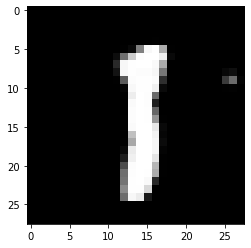

In [25]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided

G_img= G(latent_z[0])
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [20]:
loss1

tensor(0.1168, device='cuda:0', grad_fn=<MseLossBackward>)

In [21]:
Classifier_model_logits(G(z_semi))[0]

tensor([[0.0538, 0.0436, 0.0040, 0.0069, 0.1645, 0.1486, 0.1347, 0.0987, 0.1679,
         0.1772]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
#Find the journey of the digits

torch.cuda.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.optim as optim
import torch

torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.01

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.Adam([z_semi], lr=0.01)


#using latent dimension distance
latent_z_journey = [z_org]
for cnt in range(0,1,1):
  z_semi = z_org.clone().detach().to(device)

  overall_loss = 0
  i=1
  while (i<=10000):
    z_semi.requires_grad = True
        
    loss1 = criterion1(z_org,z_semi) # distance using MSE
    loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))

       
    #loss =  loss1 + loss2  # without PR
    loss = loss1 + loss2 + 0.1*loss3 #with PR
    #print(loss)
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()

    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - (z_semi.grad * step_size)
    i = i+1
    overall_loss= overall_loss + loss 
    
    if (i%100==0):
           
      avg_loss = overall_loss/50.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      overall_loss = 0 
      latent_z_journey.append(z_semi)
  

  
  

In [ ]:
####----------Baseline------------------------
#Find the journey of the digits 

import torch.optim as optim
import torch
torch.cuda.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(100)

step_size = 0.01

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.Adam([z_base], lr=0.01)


#using latent dimension distance
latent_z_journey_base = [z_org]
for cnt in range(0,1,1):
  z_base = z_org.clone().detach().to(device)

  overall_loss = 0
  i=1
  while (i<=4000):
    z_base.requires_grad = True
        
    loss1 = criterion1(z_org,z_base) # distance using MSE
    loss2 = CE_loss(Classifier_model_logits(G(z_base))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_base)), torch.tensor([1.0]).to(device))

       
    loss =  loss1 + loss2  # without PR
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    
    z_base.requires_grad = False
    z_base = z_base - z_base.grad * step_size
    i = i+1
    overall_loss= overall_loss + loss 

    if (i%50==0):
           
      avg_loss = overall_loss/50.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      overall_loss = 0 
      latent_z_journey_base.append(z_base)
 

  
  

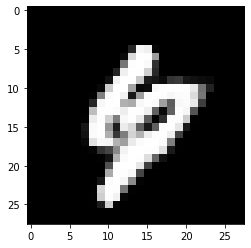

In [35]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided

G_img= G(z_base)
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

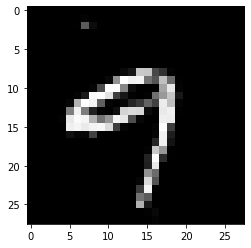

In [48]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided

G_img= G(z_semi)
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

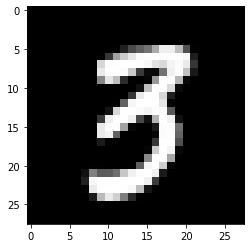

In [127]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided

G_img= G(z_org)
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


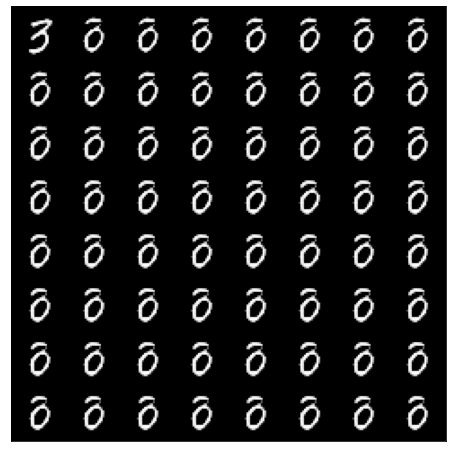

In [123]:
imgs_grid = torch.tensor([]).to(device)

for i in range(64):
  
   imgs_grid = torch.cat([imgs_grid,  G(latent_z_journey_base[i])], dim=0)


imgs_grid = imgs_grid.to('cpu')
imshow(imgs_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


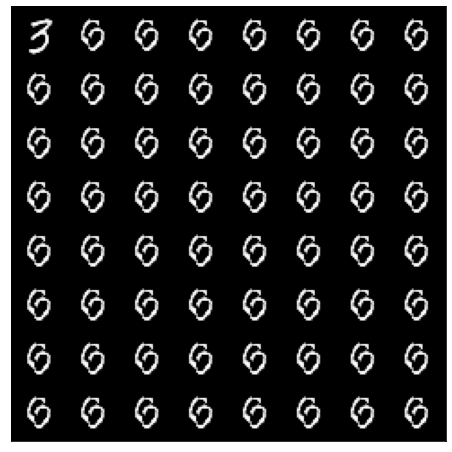

In [124]:
imgs_grid = torch.tensor([]).to(device)

for i in range(64):
  
   imgs_grid = torch.cat([imgs_grid,  G(latent_z_journey[i])], dim=0)


imgs_grid = imgs_grid.to('cpu')
imshow(imgs_grid)

In [42]:
loss1

tensor(0.7098, device='cuda:0', grad_fn=<MseLossBackward>)

In [49]:
D(G(z_semi))

tensor([0.0113], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [126]:
Classifier_model_logits(G(z_base))[0]

tensor([[9.9376e-01, 4.7832e-07, 1.5792e-03, 1.2010e-03, 4.5152e-08, 5.4027e-06,
         6.9405e-04, 1.1046e-07, 2.7528e-03, 1.1439e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [125]:
Classifier_model_logits(G(z_semi))[0]

tensor([[9.7103e-01, 3.4117e-07, 6.4125e-06, 1.5436e-04, 4.5166e-07, 1.2260e-03,
         3.5467e-03, 2.3226e-07, 1.8697e-02, 5.3373e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

## Counterfactual Based on diversity

In [ ]:
#Find the Cfs using loss function which also takes into consideration the pixel loss

"""
Loss1 - L1 dist between z and z org
Loss4 - L1 dist between sample img and G(z)
Loss2 - CE loss for intended class
Loss3 - Plausibility loss
Loss5 - Diversity Loss based on L1 distance
"""

torch.cuda.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.optim as optim
import torch

torch.manual_seed(100)
z_semi = torch.randn(2, 100,1,1).to(device) # start with random variables
step_size = 0.01

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
diversity_loss = nn.CosineEmbeddingLoss()
#print(diversity_loss(z_semi,z_org,torch.tensor([1]).to(device)))



#using latent dimension distance
latent_z_journey = []
for cnt in range(4,5,1):
  #z_semi = z_org.clone().detach().to(device) # starting with the same image gives same results
  z_original_array = z_org.clone().detach().to(device)
  sample_img_array = sample_image.clone().detach().to(device)
  
  for i in range(1): #Images based on 
   z_original_array = torch.cat([z_original_array, z_original_array] , dim=0)
   sample_img_array = torch.cat([sample_img_array, sample_img_array] , dim=0)

  overall_loss = 0
  i=1
  while (i<=10000):
    z_semi.requires_grad = True
        
    loss1 = l1_loss(z_original_array,z_semi) # distance using L1
    loss4 = l1_loss(sample_img_array,G(z_semi))
    loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt,cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0,1.0]).to(device))
    #loss5 = diversity_loss(z_semi[0], z_semi[1],torch.tensor([-1]).to(device))
    loss5 = l1_loss(z_semi[0], z_semi[1]) # distance between both the images
       
    #loss =  loss1 + loss2 + loss4 # without PR
    loss = loss1 + loss2 + loss4 -loss5  + loss3 #with PR
       
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    
    z_semi.requires_grad = False
    z_semi = z_semi - (z_semi.grad * step_size)
  
    if (i%100==0):
           
      avg_loss = overall_loss/100.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      overall_loss = 0 
      latent_z_journey.append(z_semi)
  

  
  

In [ ]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided


G_img= G(z_semi[0,:,:,:].unsqueeze(0))
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [ ]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided


G_img= G(z_semi[1,:,:,:].unsqueeze(0))
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

## Semifactual calculation using standard losses

In [ ]:
#Using nn.losses

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.1

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.SGD([z_semi], lr=0.01)


#using latent dimension distance
latent_z = []
for cnt in range(2,3,1):
  z_semi = z_org.to(device)
  arg_max = 0.01
  overall_loss = 0
  i=1
  
  while (i<=5000  ):
    z_semi.requires_grad = True
        
    loss1 = criterion1(z_org,z_semi) # distance using MSE
    loss2 = criterion1(Classifier_model_logits(G(z_semi))[0][0][0],Classifier_model_logits(G(z_semi))[0][0][0] )
    #loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))
    loss4=  criterion1(Classifier_model_logits(G(z_semi))[1],torch.tensor([1.0]).to(device) )
    arg_max = torch.argmax(Classifier_model_logits(G(z_semi))[0][0])
    #print(arg_max)
       
    #loss =  loss1 + loss2  # without PR
    loss = loss1 + loss2 + loss4 +0.01*loss3 #with PR
    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1
    
    overall_loss= overall_loss + loss 

    if (i%500==0):
           
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
     
      overall_loss = 0 
  latent_z.append(z_semi)
  
  

In [ ]:


G_img= G(z_semi) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

##Distant and yet same prediction

In [146]:
#Using latent dimension loss

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.1

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.SGD([z_semi], lr=0.01)


#using latent dimension distance
latent_z = []
for cnt in range(2,3,1):
  z_semi = z_org.to(device)
  arg_max = 0.01
  overall_loss = 0
  i=1
  
  while (i<=30000  ):
    z_semi.requires_grad = True
        
    loss1 = l1_loss(z_org,z_semi) # distance using MSE
    #loss2 = criterion1(Classifier_model_logits(G(z_semi))[0][0][0],Classifier_model_logits(G(z_semi))[0][0][0] )
    loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([3]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))
    #loss4=  CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([3]).to(device) ) # maintain the given class



    #loss =  loss1 + loss2  # without PR
    loss = -loss1 + loss2 + loss3  #with PR
    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1
    
    overall_loss= overall_loss + loss 

    if (i%5000==0):
           
      avg_loss = overall_loss/5000.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
     
      overall_loss = 0 
  latent_z.append(z_semi)
  
  

avg_loss step  5000tensor(-3.0032, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  10000tensor(-7.6776, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  15000tensor(-12.0811, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  20000tensor(-16.4946, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  25000tensor(-20.8831, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  30000tensor(-25.2616, device='cuda:0', grad_fn=<DivBackward0>)


(1, 28, 28)


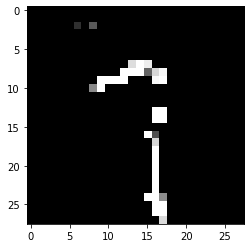

In [147]:
#Visualize the results

G_img= G(z_semi) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [148]:
Classifier_model_logits(G(z_semi))[0]

tensor([[1.2844e-05, 1.0625e-04, 1.6681e-03, 9.4879e-01, 8.4761e-08, 4.7154e-04,
         2.3684e-06, 4.8433e-02, 3.3756e-05, 4.8518e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [150]:
loss1

tensor(27.5723, device='cuda:0', grad_fn=<L1LossBackward>)

In [149]:
D(G(z_semi))

tensor([0.9344], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [ ]:
#Visualize the original image

G_img= G(z_org) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')


In [ ]:
#Using pixel distance

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.1

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.SGD([z_semi], lr=0.01)


#using latent dimension distance
latent_z = []
for cnt in range(2,3,1):
  z_semi = z_org.to(device)
  arg_max = 0.01
  overall_loss = 0
  i=1
  
  while (i<=30000  ):
    z_semi.requires_grad = True
        
    loss1 = l1_loss(G(z_org),G(z_semi)) # distance using MSE
    #loss2 = criterion1(Classifier_model_logits(G(z_semi))[0][0][0],Classifier_model_logits(G(z_semi))[0][0][0] )
    #loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))
    loss4=  CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([5]).to(device) )



    #loss =  loss1 + loss2  # without PR
    loss = -loss1 + loss4 + loss3 #with PR
    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1
    
    overall_loss= overall_loss + loss 

    if (i%5000==0):
           
      avg_loss = overall_loss/5000.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
     
      overall_loss = 0 
  latent_z.append(z_semi)
  
  

In [ ]:
#Visualize the results

G_img= G(z_semi) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

## Experiments

In [254]:
#Find the Cfs using loss function which also takes into consideration the pixel loss

"""
Loss1 - L1 dist between z and z org
Loss4 - L1 dist between sample img and G(z)
Loss2 - CE loss for intended class
Loss3 - Plausibility loss
"""

torch.cuda.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.optim as optim
import torch

torch.manual_seed(100)
z_semi = torch.randn(2, 100,1,1).to(device)
step_size = 0.01
min_loss = 100
#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
diversity_loss = nn.CosineEmbeddingLoss()
#print(diversity_loss(z_semi,z_org,torch.tensor([1]).to(device)))
#optimizer = optim.Adam([z_semi], lr=0.01)


#using latent dimension distance
latent_z_journey = []
for cnt in range(5,6,1):
  #z_semi = z_org.clone().detach().to(device)
  z_original_array = z_org.clone().detach().to(device)
  sample_img_array = sample_image.clone().detach().to(device)
  for i in range(1):
  
   #z_semi = torch.cat([z_semi, z_semi] , dim=0)
   z_original_array = torch.cat([z_original_array, z_original_array] , dim=0)
   sample_img_array = torch.cat([sample_img_array, sample_img_array] , dim=0)

  overall_loss = 0
  i=1
  while (i<=10000):
    z_semi.requires_grad = True
        
    loss1 = torch.mean(torch.abs(z_semi)) # distance using L1
    loss4 = l1_loss(sample_img_array,G(z_original_array + z_semi))
    loss2 = CE_loss(Classifier_model_logits(G(z_original_array + z_semi))[1],torch.tensor([cnt,cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_original_array + z_semi)), torch.tensor([1.0,1.0]).to(device))
    #loss5 = diversity_loss(z_semi[0], z_semi[1],torch.tensor([-1]).to(device))
    loss5 = l1_loss(z_original_array + z_semi[0], z_semi[1])

       
    #loss =  loss1 + loss2 + loss4 # without PR
    loss = loss1 + loss2 + loss4 -loss5  + loss3 #with PR
    #print(loss5)
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()

    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - (z_semi.grad * step_size)

    if(loss1>0.9):
      print("loss 1 higher")
      z_semi = z_semi - (z_semi -0.9) 
    
    i = i+1
    overall_loss= overall_loss + loss 
    
    if (i%100==0):
           
      avg_loss = overall_loss/100.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      #print(loss5)
      overall_loss = 0 
      latent_z_journey.append(z_semi)
      if(avg_loss<min_loss):
        min_loss = avg_loss
        z_semi_final = z_semi

  

  
  

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([2, 100, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


avg_loss step  100tensor(0.7417, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  200tensor(-0.2055, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  300tensor(-0.3302, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  400tensor(-0.3988, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  500tensor(-0.4352, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  600tensor(-0.4624, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  700tensor(-0.4916, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  800tensor(-0.5225, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  900tensor(-0.5460, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1000tensor(-0.5671, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1100tensor(-0.5874, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1200tensor(-0.6043, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1300tensor(-0.6196, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1400ten

KeyboardInterrupt: ignored

In [249]:
loss1

tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)

In [250]:
loss5

tensor(0.8192, device='cuda:0', grad_fn=<L1LossBackward>)

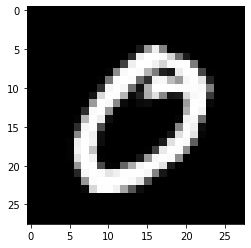

In [224]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided

G_img= G(z_org)
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

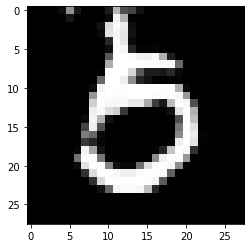

In [246]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided


G_img= G((z_original_array + z_semi_final)[1,:,:,:].unsqueeze(0))
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

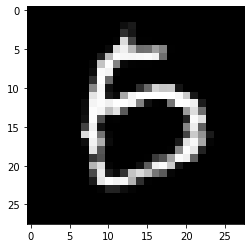

In [247]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided


G_img= G((z_original_array + z_semi_final)[0,:,:,:].unsqueeze(0))
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [251]:
D(G((z_original_array + z_semi)[0,:,:,:].unsqueeze(0)))

tensor([0.6883], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [252]:
l1_loss(G(z_semi[1,:,:,:].unsqueeze(0)), sample_image)

tensor(0.2895, device='cuda:0', grad_fn=<L1LossBackward>)

In [253]:
Classifier_model_logits(G((z_original_array + z_semi)[1,:,:,:].unsqueeze(0)))[0]

tensor([[1.0000e+00, 4.8674e-14, 4.0598e-12, 4.3837e-16, 7.1081e-17, 2.9398e-11,
         2.3440e-07, 5.7049e-13, 2.5084e-13, 2.7069e-13]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


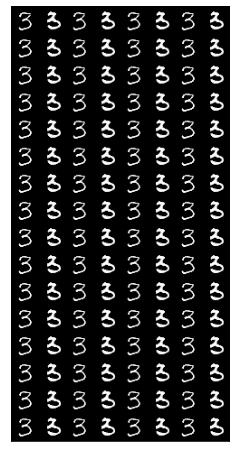

In [170]:
imgs_grid = torch.tensor([]).to(device)

for i in range(64):
  
   imgs_grid = torch.cat([imgs_grid,  G(latent_z_journey[i])], dim=0)


imgs_grid = imgs_grid.to('cpu')
imshow(imgs_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


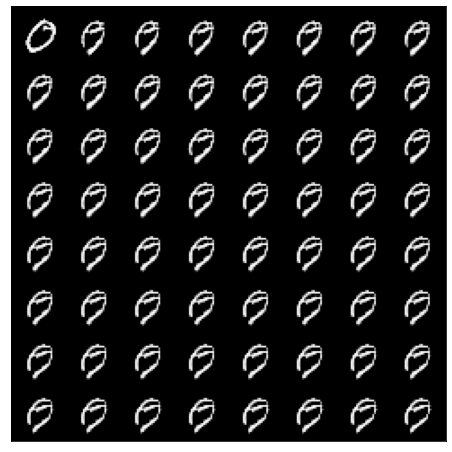

In [69]:
imgs_grid = torch.tensor([]).to(device)

for i in range(64):
  
   imgs_grid = torch.cat([imgs_grid,  G(latent_z_journey[i])], dim=0)


imgs_grid = imgs_grid.to('cpu')
imshow(imgs_grid)

In [77]:
diversity_loss = nn.CosineEmbeddingLoss()
print(diversity_loss(z_semi,z_org,torch.tensor([1]).to(device)))

tensor(0.0122, device='cuda:0')


In [85]:
z_semi = z_org.clone().detach().to(device)
  
for i in range(2):
  z_semi = torch.cat([z_semi, z_semi] , dim=0)

In [86]:
z_semi.shape

torch.Size([4, 100, 1, 1])

In [84]:
z_org.shape

torch.Size([1, 100, 1, 1])

In [191]:
loss1

tensor(1.1983, device='cuda:0', grad_fn=<L1LossBackward>)